In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix, f1_score


import acquire as acq
import prepare as prep

---
---
## Titanic Dataset 

***
### Decision Trees
#### Acquire data

In [5]:
# acquire titanic data
df = acq.getData('titanic')
#prep the data, use default 70/20/10
tr, te, val = prep.prep_titanic(df)
#Create training backup
tr_b = tr
#take a peek
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 212 to 723
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   survived                 622 non-null    int64  
 1   sex                      622 non-null    object 
 2   age                      622 non-null    float64
 3   sibsp                    622 non-null    int64  
 4   parch                    622 non-null    int64  
 5   fare                     622 non-null    float64
 6   pclass                   622 non-null    object 
 7   embark_town              622 non-null    object 
 8   alone                    622 non-null    int64  
 9   embark_town_Queenstown   622 non-null    uint8  
 10  embark_town_Southampton  622 non-null    uint8  
 11  sex_male                 622 non-null    uint8  
 12  class_Second             622 non-null    uint8  
 13  class_Third              622 non-null    uint8  
dtypes: float64(2), int64(4),

/Users/caytschlichting/codeup-data-science/classification-exercises/prepare.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate['age'] = imputer.transform(validate[['age']])


#### 1) Create baseline and determine accuracy

In [6]:
#Create new results DF
tr_res = pd.DataFrame(tr.survived)
tr_res.rename(columns={'survived':'actual'},inplace=True)
#create new columne with baseline
tr_res['baseline'] = tr.survived.mode()[0]
#check
tr_res.describe().T

,count,mean,std,min,25%,50%,75%,max
actual,622.0,0.382637,0.486422,0.0,0.0,0.0,1.0,1.0
baseline,622.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [7]:
#1) baseline accuracy
print(f'The baseline accuracy is: {accuracy_score(tr_res.actual,tr_res.baseline)}')

The baseline accuracy is: 0.617363344051447


#### 2) Fit decision tree classifier

In [8]:
#Create subsets for model input and testing
#drop target and non-encoded categories
X_tr = tr.drop(columns=["survived","sex","pclass","embark_town"])
#create target subset
y_tr = tr.survived

X_te = te.drop(columns=["survived","sex","pclass","embark_town"])
y_te = te.survived

X_val = val.drop(columns=["survived","sex","pclass","embark_town"])
y_val = val.survived


In [9]:
#create classifier - default gini, depth 3
#REVISIT this and play around with class_weight
clf3 = DecisionTreeClassifier(max_depth=3,random_state=88)
#fit it to train data
clf3 = clf3.fit(X_tr,y_tr)


[Text(279.0, 332.955, 'sex_male <= 0.5\ngini = 0.472\nsamples = 622\nvalue = [384, 238]\nclass = 0'),
 Text(139.5, 237.825, 'class_Third <= 0.5\ngini = 0.4\nsamples = 221\nvalue = [61, 160]\nclass = 1'),
 Text(69.75, 142.695, 'age <= 3.0\ngini = 0.125\nsamples = 119\nvalue = [8, 111]\nclass = 1'),
 Text(34.875, 47.565, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = 0'),
 Text(104.625, 47.565, 'gini = 0.112\nsamples = 118\nvalue = [7, 111]\nclass = 1'),
 Text(209.25, 142.695, 'fare <= 24.808\ngini = 0.499\nsamples = 102\nvalue = [53, 49]\nclass = 0'),
 Text(174.375, 47.565, 'gini = 0.492\nsamples = 85\nvalue = [37, 48]\nclass = 1'),
 Text(244.125, 47.565, 'gini = 0.111\nsamples = 17\nvalue = [16, 1]\nclass = 0'),
 Text(418.5, 237.825, 'age <= 3.5\ngini = 0.313\nsamples = 401\nvalue = [323, 78]\nclass = 0'),
 Text(348.75, 142.695, 'sibsp <= 2.0\ngini = 0.32\nsamples = 10\nvalue = [2, 8]\nclass = 1'),
 Text(313.875, 47.565, 'gini = 0.0\nsamples = 7\nvalue = [0, 7]\nclass = 1'),
 Text(3

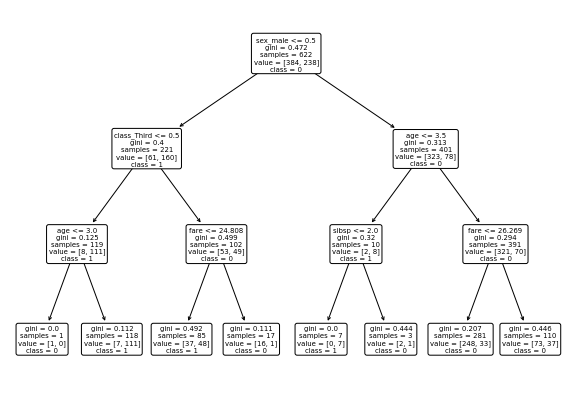

In [10]:
#Visualize the model:
plt.figure(figsize=(10,7))
plot_tree(clf3, feature_names=X_tr.columns, class_names=clf3.classes_.astype(str),rounded=True)

#### 3) Evaluate model score, confusion matrix and classification report on sample

In [11]:
# #create df of models
# clf_df = pd.DataFrame()
# #add this first model to our clf dataframe
# clf_df['model_d3'] = clf

#add model train output to results dataframe
tr_res['model_d3'] = clf3.predict(X_tr)

In [12]:
#View confusion matrix:
pd.crosstab(tr_res.model_d3,tr_res.actual)

actual,0,1
model_d3,,
0,340,72
1,44,166


In [13]:
#View classification report
print(classification_report(tr_res.actual,tr_res.model_d3))

              precision    recall  f1-score   support

           0       0.83      0.89      0.85       384
           1       0.79      0.70      0.74       238

    accuracy                           0.81       622
   macro avg       0.81      0.79      0.80       622
weighted avg       0.81      0.81      0.81       622



In [14]:
#Model score (aka accuracy)
print(f'The accuracy of the model {clf3.score(X_tr,y_tr)}')

The accuracy of the model 0.8135048231511254


#### 4) Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.
- true positive rate = recall = sensitivity = TP / (TP + FN)
- false negative rate =  miss rate = FN/(TP + FN)
- true negative rate = specificity = TN / (TN + FP)
- false positive rate = FP/(TN + FP)

NOTE: The denominator of the rates are determined by the total actual values (P or N) that correspond to the actual value associated with the numerator.


In [15]:
def print_model_stats(act,mod,pos,**kwargs):
    """
    Gets model statistics.  Only handles binary target variables at the moment.
    Parameters:
      (R) -    act: pandas series of actual target values
      (R) -    mod: pandas series of modeled target values (must be same length as act)
      (R) -    pos: positive outcome for target variable 
      (O) - ret_DF: If True, returns statistics in the form of a pandas dataframe.  
                    If False, prints statistics on screen (Default False)
                    
    NOTE:  
    recall = sensitivity = true positive rate
    miss rate = false negative rate
    specificity = true negative rate    
    """
    #Get return df parameter.  Default is false, which returns none and prints the statistics
    ret_df = kwargs.get('ret_df',False)
    
    #Create label list - binary confusion matrix needs positive value last
    #populate rest of list with possible outcomes
    oth=list(act.unique())
    oth.remove(pos)
    labels = oth +[pos]
    
    #run confusion matrix
    cm = confusion_matrix(act,mod,labels=labels)
    
    #If two target variables ravel cm, else break softly
    if len(labels) == 2: 
        tn, fp, fn, tp = cm.ravel()
    else: 
        print('function cannot handle greater than 2 target variable outcomes')
        return None
    
    #Calculate all the model scores
    recall = recall_score(act,mod,pos_label=pos,zero_division=0)
    precision = precision_score(act,mod,pos_label=pos,zero_division=0)
    f1 = f1_score(act,mod,pos_label=pos,zero_division=0)
    acc = accuracy_score(act,mod)
    fnr = fn/(tp+fn)
    fpr = fp/(tn+fp)
    
    ### TO DO: CALCULATE THE REST OF THE MODEL STATISTICS
    if ret_df:
        ### TO DO: CREATE DATAFRAME - COLUMNS TO BE STATISTIC VALUES (aka scores)
        return df
    else:
        print(f'\033[1mModel: {mod.name}  Positive: {pos}\033[0m')
        print(f'TP: {tp}   FP: {fp}')
        print(f'FN: {fn}   TN: {tn}')
        print(f'      Accuracy: {acc:.3f}')
        print(f'     Precision: {precision:.3f}')
        print(f'        Recall: {recall:.3f}')
        print(f'      F1 score: {f1:.3f}')
        print(f'False neg rate: {fnr:.3f}')
        print(f'False pos rate: {fpr:.3f}')      
        return None
    

In [16]:
#positive target is going to be survived (1)
print_model_stats(tr_res.actual,tr_res.baseline,1)

Model: baseline  Positive: 1
TP: 0   FP: 0
FN: 238   TN: 384
      Accuracy: 0.617
     Precision: 0.000
        Recall: 0.000
      F1 score: 0.000
False neg rate: 1.000
False pos rate: 0.000


#### 5) Run through steps 2-4 using a different max_depth value.

In [17]:
#create classifier - default gini, depth 3
clf2 = DecisionTreeClassifier(max_depth=2,random_state=88)
#fit it to train data
clf2 = clf2.fit(X_tr,y_tr)

#add this model to our results dataframe
model_name = "model_d" + str(2)
tr_res[model_name] = clf2.predict(X_tr)

#print crosstab and confusion matrix:
print(f'\033[1m{model_name}\033[0m')
pd.crosstab(tr_res[model_name],tr_res.actual)
print(classification_report(tr_res.actual,tr_res[model_name]))

#print all the stats
print_model_stats(tr_res.actual,tr_res[model_name],1)

#space between next output:
print('\n\n')

#create classifier - default gini, depth 3
clf4 = DecisionTreeClassifier(max_depth=4,random_state=88)
#fit it to train data
clf4 = clf4.fit(X_tr,y_tr)

#add this model to our results dataframe
model_name = "model_d" + str(4)
tr_res[model_name] = clf4.predict(X_tr)

#print crosstab and confusion matrix:
print(f'\033[1m{model_name}\033[0m')
pd.crosstab(tr_res[model_name],tr_res.actual)
print(classification_report(tr_res.actual,tr_res[model_name]))

#print all the stats
print_model_stats(tr_res.actual,tr_res[model_name],1)

model_d2
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       384
           1       0.92      0.50      0.65       238

    accuracy                           0.79       622
   macro avg       0.84      0.74      0.75       622
weighted avg       0.82      0.79      0.77       622

Model: model_d2  Positive: 1
TP: 119   FP: 10
FN: 119   TN: 374
      Accuracy: 0.793
     Precision: 0.922
        Recall: 0.500
      F1 score: 0.649
False neg rate: 0.500
False pos rate: 0.026



model_d4
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       384
           1       0.79      0.71      0.75       238

    accuracy                           0.82       622
   macro avg       0.81      0.80      0.81       622
weighted avg       0.82      0.82      0.82       622

Model: model_d4  Positive: 1
TP: 170   FP: 44
FN: 68   TN: 340
      Accuracy: 0.820
     Precision: 0.794
        Recall: 0.714


#### 6) Which model performs better on your in-sample data?
Looking at the output below, all non-baseline models have high accuracy that are relatively similar.
Models of depth 3 and 4 have beeter F1 scores

In [18]:
for i in tr_res.columns[1:]:
    print_model_stats(tr_res.actual,tr_res[i],1)

Model: baseline  Positive: 1
TP: 0   FP: 0
FN: 238   TN: 384
      Accuracy: 0.617
     Precision: 0.000
        Recall: 0.000
      F1 score: 0.000
False neg rate: 1.000
False pos rate: 0.000
Model: model_d3  Positive: 1
TP: 166   FP: 44
FN: 72   TN: 340
      Accuracy: 0.814
     Precision: 0.790
        Recall: 0.697
      F1 score: 0.741
False neg rate: 0.303
False pos rate: 0.115
Model: model_d2  Positive: 1
TP: 119   FP: 10
FN: 119   TN: 374
      Accuracy: 0.793
     Precision: 0.922
        Recall: 0.500
      F1 score: 0.649
False neg rate: 0.500
False pos rate: 0.026
Model: model_d4  Positive: 1
TP: 170   FP: 44
FN: 68   TN: 340
      Accuracy: 0.820
     Precision: 0.794
        Recall: 0.714
      F1 score: 0.752
False neg rate: 0.286
False pos rate: 0.115


#### 7) Which model performs best on your out-of-sample data?
Looking at the output below, the two models perform very similarly on the validate dataset.  Because of this, I would choose to move forward with model_d3, as it provides similar results with less fitting.

In [19]:
val_res = pd.DataFrame()
val_res['actual'] = y_val
val_res['model_d3'] = clf3.predict(X_val)
val_res['model_d4'] = clf4.predict(X_val)

for i in val_res.columns[1:]:
    print_model_stats(val_res.actual,val_res[i],1)


Model: model_d3  Positive: 1
TP: 48   FP: 8
FN: 20   TN: 102
      Accuracy: 0.843
     Precision: 0.857
        Recall: 0.706
      F1 score: 0.774
False neg rate: 0.294
False pos rate: 0.073
Model: model_d4  Positive: 1
TP: 49   FP: 9
FN: 19   TN: 101
      Accuracy: 0.843
     Precision: 0.845
        Recall: 0.721
      F1 score: 0.778
False neg rate: 0.279
False pos rate: 0.082


### Random Forest
#### Create and fit random forest classifier

In [34]:
#create random forest classifier
model = RandomForestClassifier(max_depth=10,min_samples_leaf=1,random_state=88)
#fit with training data
model.fit(X_tr,y_tr)
#predict off training data
tr_res['rf_msl1_d10'] = model.predict(X_tr)

In [35]:
#Set positive case as survived = 1
pos=1
#print all kinds of info
print(classification_report(tr_res.actual,tr_res.rf_msl1_d10))
print_model_stats(y_tr,tr_res['rf_msl1_d10'],pos)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       384
           1       0.98      0.90      0.94       238

    accuracy                           0.95       622
   macro avg       0.96      0.94      0.95       622
weighted avg       0.95      0.95      0.95       622

Model: rf_msl1_d10  Positive: 1
TP: 214   FP: 5
FN: 24   TN: 379
      Accuracy: 0.953
     Precision: 0.977
        Recall: 0.899
      F1 score: 0.937
False neg rate: 0.101
False pos rate: 0.013


In [45]:
#Now do the same thing with modified rfc params
#outer list is each model, inner list is [min_sample_leaf,max_depth]
params = [[1,10], [2,8], [3,7]] 
#Note that I included the original params [1,10] and this will overwrite those results

#create new dictionary of models
model_dict ={}
#Loop over our desired parameter combinations and create, fit and predict model for each
for i in params:
    #grab parameters
    msl = i[0]
    md = i[1]
    #create model name
    model_name = 'rf_msl'+ str(msl) +'_d'+ str(md)
    
    #create model & fit
    rf = RandomForestClassifier(max_depth=md,min_samples_leaf=msl,random_state=88)
    rf = rf.fit(X_tr,y_tr)
    
    #Get predictions and store to train results - SAME DF FOR ALL TITANIC    
    tr_res[model_name] = rf.predict(X_tr)
    
    #Now store everything in our dictionary
    model_dict[model_name] = {
        "model_name": model_name,
        "model":rf,
        "model_type": "RandomForestClassifier",
        "min_samples_leaf":msl,
        "max_depth":md
    }
    #FUTURE: would update print_model_stats to return pd.df or dict to update model_dict with stats

msl: 1  md: 10
msl: 2  md: 8
msl: 3  md: 7


In [47]:
#Now let's look at the stats for each of these
# for mn, d in model_dict:
#     print_model_stats(tr_res)

#reiterate that positive is 1 for survived
pos=1
for m in tr_res.columns:
    if m.startswith('rf'):
        print_model_stats(tr_res.actual,tr_res[m],pos)

Model: rf_msl1_d10  Positive: 1
TP: 214   FP: 5
FN: 24   TN: 379
      Accuracy: 0.953
     Precision: 0.977
        Recall: 0.899
      F1 score: 0.937
False neg rate: 0.101
False pos rate: 0.013
Model: rf_msl2_d8  Positive: 1
TP: 185   FP: 17
FN: 53   TN: 367
      Accuracy: 0.887
     Precision: 0.916
        Recall: 0.777
      F1 score: 0.841
False neg rate: 0.223
False pos rate: 0.044
Model: rf_msl3_d7  Positive: 1
TP: 178   FP: 19
FN: 60   TN: 365
      Accuracy: 0.873
     Precision: 0.904
        Recall: 0.748
      F1 score: 0.818
False neg rate: 0.252
False pos rate: 0.049


# RETURN HERE:
- Do random forest exercises #5 (in other words look at the output above and say smart things)

## Telco Dataset
### Decision Trees

#### Acquire Data and create X and y subsets

In [ ]:
df = acq.getData('telco')
#Using split of 70/20/10 tr/te/val
tr, te, val = prep.prep_telco(df)

tr.info()

In [ ]:
drp_cols = list(tr.select_dtypes(object).columns)
drp_cols.append('has_churned')
drp_cols

In [ ]:
#Create subsets for model input
X_tr = tr.drop(columns=drp_cols)
y_tr = tr.churn

X_te = te.drop(columns=drp_cols)
y_te = te.churn

X_val = val.drop(columns=drp_cols)
y_val = val.churn

In [ ]:
X_tr.head(2)

#### Create baseline

In [ ]:
#create training result dataframe, populate with actual values
tr_res = pd.DataFrame(tr.churn)
#rename column to actual
tr_res.rename(columns={'churn':'actual'},inplace=True)
#create baseline model
tr_res['baseline'] = tr_res.actual.mode()[0]

tr_res.describe()

#### Create models
- Want depth of 3 to 10.  Going that high because some depth levels may be less useful
- No significant nulls in data, so don't want to modify weights
- Ideally would modify columns in X_tr to prevent model from choosing decision points that are directly related
  - EX: for things like streaming, we really could just remove 

In [ ]:
# clf_dict2 = {}
clf_list = []
for i, val in enumerate(range(3,11)):
    #create model name
    model_name = "model_d" + str(val)
    #create and fit model
    clf = DecisionTreeClassifier(max_depth=val,random_state=88)
    clf = clf.fit(X_tr,y_tr)
#     #Store model in dictionary.  Key is model name, value is model
#     clf_dict2[model_name] = clf
    
    #Store model information as a dictionary, within a list
    clf_list.append({
        "model_name": model_name,
        "model": clf
    })   

In [ ]:
clf_list[0:2]

#### Get model predictions on train subset

# KEEP WORKING HERE.  
## UPDATE print_model_stats TO BE ABLE TO STORE STATS IN DICTIONARY 

In [ ]:
#Loop over the list of dictionaries/models
for d in clf_list:
    #pull out model
    clf=d['model']
    #generate training values and assign to result df under the model name
    tr_res[d['model_name']] = clf.predict(X_tr)  
    
tr_res.shape

#### Print Model Statistics
Looking at the output below, I am most concerned with missing a person who will churn (by thinking they won't).  So I want to minimize false negatives (good recall), while still having a decent accuracy.

Models I want to run past the Validate sets:
- d4, because it has best recall (.58) with relatively low depth and good accuracy (.79).
- d10, because it has good numbers across the board, though I suspect it will over-fit
- d8, because it increase recall to .64 and accuracy to .84, with a lower depth than d10

In [ ]:
#This would look better all together as a DF, but may still want to store it in the dictionary for each model
#So probably want to reformat this info as a DF at some point, for now I'll just print stats to screen

#positive case is churn == Yes, want my models to identify customers who may churn
pos = 'Yes'

#Loop over all model predictions and print their stats
for i in tr_res.columns[1:]:
    print_model_stats(tr_res.actual,tr_res[i],pos)

#### Run select models on the validate subset

In [ ]:
#Create df to hold model outputs:
val_res = pd.DataFrame(y_val)
val_res.rename(columns={'churn':'actual'},inplace=True)

#list of models I want to look at
v_models = ['model_d4','model_d8','model_d10']

for d in clf_list:
    if d['model_name'] in v_models:
        #Grab the model
        clf = d['model']
        #Predict values for each model
        val_res[d['model_name']] = clf.predict(X_val)
#         #Output most important features while we're at it
#         print(clf.feature_importances_)

val_res.columns

#### Look at how the models did on the validate data
Looking at the output, we can see the d8 and d10 did overfit the train set and d4 had the best recall and accuracy of the 3 models at recall = .575 and accuracy = .778

In [ ]:
for i in val_res.columns[1:]:
    print_model_stats(val_res.actual,val_res[i],pos) #pos is still 'Yes'

#### Now let's visualize that decision tree

In [ ]:
#pull out the model
for d in clf_list:
    if d['model_name'] == 'model_d4':
        clf = d['model']
        break

plt.figure(figsize=(15,10))
plot_tree(clf, feature_names=X_tr.columns, class_names=clf.classes_.astype(str),rounded=True)

In [ ]:
# #This can be used later for looping over the models
# for k in clf_dict.items():
#     i.value
#     i.key